In [27]:
import numpy as np 

np.random.seed(42) # the only random seed i need

# Exercise (3)

Goal of this exercise is to implement the **Bisection** Method for symmetrical matrizes to find the eigenvalues. For this we want to calculate the eigenvalues of the following matrix

\begin{equation}
A = \begin{pmatrix}
-2 & 1 & 0 & ...& 0 \\
1 & ...& ...& ...& 0 \\
0 & ...& ...& ...& 0 \\
... & ... & ... & ... & 0 \\
0 & 0 & 0 & 1 & -2 
\end{pmatrix} \in \mathbb{R}^{10 \times 10}
\end{equation}

At first we bring the matrix to the Hessenberg form. We are allowed to use **scipy.linalg.hessenberg** for this.






### Definition Hessenberg-Form

A square matrix with $h_{ij} = 0$ for $i\geq j+2$ is called Hessenberg-Matrix

Transformation with Householder-Reflections.

Remember that the Householder-Reflection is defined as

\begin{equation}
H = I - 2 u u^T
\end{equation}


**Transformation to Hessenberg-Form**

1. For each column $k$ from $0,n-2$ we identify the vector below the diagonal to zero out
2. Then create a Householder-Reflection for this Vector
3. Apply this Reflector to A from both sides

In [28]:
import numpy as np
from scipy.linalg import hessenberg

def householder_reflection(v):
    """ 
    Creates a householder reflection for the vector v
    """
    u = v.copy()
    # Choose a sign to avoid numerical issues
    u[0] += np.sign(v[0]) * np.linalg.norm(v)
    u /= np.linalg.norm(u) # Normalize u
    return np.eye(len(v)) - 2 * np.outer(u, u) # Householder matrix

def hessenberg_reduction(A):
    """
    Transforms a symmetric matrix A to tridiagonal Hessenberg form
    """
    A = A.copy().astype(float) 
    n = A.shape[0]

    for k in range(n-2):
        # Vector to zero out below the k-th subdiagonal
        x = A[k+1:, k]

        # Skip if already zero
        if np.allclose(x[1:] , 0):
            continue

        # Create householder reflection
        H_k = householder_reflection(x)

        # Embed in full size matrix
        H_full = np.eye(n)
        H_full[k+1:, k+1:] = H_k

        # Apply the transformation
        A = H_full @ A @ H_full.T
    
    return A

In [29]:
# Test matrix

A = np.array([[4, 1, 2, 3],
              [1, 5, 6, 7],
              [2, 6, 8, 9],
              [3, 7, 9, 10]])

# Hessenberg with scipy
A_scipy = hessenberg(A)
# Custom Hessenberg reduction
A_custom = hessenberg_reduction(A)
# Print results
print("---------Hessenberg form using custom function:-------------\n", A_custom)
print("")
print("---------Hessenberg form using scipy:---------------------\n", A_scipy)

# Check if the results are close
print("Are the results close?", np.allclose(A_custom, A_scipy))

---------Hessenberg form using custom function:-------------
 [[ 4.00000000e+00 -3.74165739e+00  2.43135199e-16  4.32902192e-16]
 [-3.74165739e+00  2.15000000e+01 -5.33519313e+00  7.77156117e-16]
 [ 2.43135199e-16 -5.33519313e+00  1.30301129e+00  2.05895110e-01]
 [ 4.32902192e-16  2.22044605e-16  2.05895110e-01  1.96988708e-01]]

---------Hessenberg form using scipy:---------------------
 [[ 4.00000000e+00 -3.74165739e+00  4.64923116e-16  4.22228551e-16]
 [-3.74165739e+00  2.15000000e+01 -5.33519313e+00  4.44089210e-15]
 [ 0.00000000e+00 -5.33519313e+00  1.30301129e+00  2.05895110e-01]
 [ 0.00000000e+00  0.00000000e+00  2.05895110e-01  1.96988708e-01]]
Are the results close? True


**Bisection for Symmetrical Matrices**

We set $A_1 = [d_1], A_2 = \begin{pmatrix} d_1 & e_2 \\ e_2 & d_2 \end{pmatrix}, A_3 = \begin{pmatrix} d_1 & e_2 & 0 \\ e_2 & d_2 & e_3 \\ 0 & e_3 & d_3 \end{pmatrix}, ...$ and so on.

And defines the polynomials $p_i(\lambda) = \det(A_i - \lambda I)$.

Now the Matrix $A$ defines a Sturm-Chain and $W(b)- W(a)$ is the number of eigenvalues in the interval $[a,b)$ Here $W(\lambda)$ is the number of sign changes in $[p_0(\lambda), p_1(\lambda), ..., p_n(\lambda)]$.

1. We search for a interval [a,b) such that all eigenvalues of $A$ are contained in this interval (by using Gerschogin's theorem) then $W(a) = 0, W(b) = n$ 
2. Next we set $c = (a+b)/2$ and calculate $W(c)$ 
3. $W(c) - W(a)$ is the number of eigenvalues in the interval $[a,c)$
4. $W(b) - W(c)$ is the number of eigenvalues in the interval $[c,b)$
5. Each of this interval that contains at least on eigenvalue is split sucessively

For the calculation of $p_n(\lambda)$ often overflow errors occur if $n$ is big and $|\lambda|$ is big. For this we better use

$f_i (\lambda) = \frac{p_i(\lambda)}{p_{i-1}(\lambda)}, i = 1, ..., n$

Now notice that

+ $W(\lambda)$ = Number of sign changes in [$p_0(\lambda), p_1(\lambda), ..., p_n(\lambda)$] is the same as number of negative elements in [$f_1(\lambda), f_2(\lambda), ..., f_n(\lambda)$]

#### Final remark on $f_i(\lambda)$

The sequence of $f_i(\lambda)$ fulfilles the recursion $f_1(\lambda) = d_1 - \lambda$ and 

\begin{equation}
f_i(\lambda) = \begin{cases} d_i - \lambda - \frac{e_i^2}{f_{i-1}(\lambda)}, f_{i-1}(\lambda) \neq 0 \\ -\infty , f_{i-1}(\lambda) = 0 \end{cases}
\end{equation}


Alternatively we modify the recursion to $\tilde{f}_1(\lambda = d_1 - \lambda$ and

\begin{equation}
\tilde{f}_i(\lambda) = d_1 - \lambda - \begin{cases} \frac{e_i^2}{\tilde{f}_{i-1}(\lambda)}, if |\tilde{f}_{i-1}(\lambda)| \geq |e_i|*eps \\
\frac{|e_i|}{eps} ~ if |\tilde{f}_{i-1}(\lambda)| < |e_i|*eps \\ 
\end{cases}
\end{equation}

In [30]:
def sturm_sequence_recursion(A, lam):
    """
    Compute W(\lambda) using the ratio approach f_i = p_i / p_{i-1}
    
    Uses the recurison formula given in the script
    """
    n = A.shape[0]
    d = np.diag(A) - lam # Diagonal elements minus lambda
    e = np.diag(A, k=-1) # subdiagonal elements

    # Initialize p_0(lamda) = 1
    if n == 0:
        return 0, np.array([])

    f_values = np.zeros(n)
    f_values[0] = d[0] #f_1 = d_1 - \lambda

    

    count = 1 if f_values[0] < 0 else 0 # Initialize the count

    for i in range(1,n):
        if np.isclose(f_values[i-1], 0, atol=1e-12):
            # Special case when f_{i-1} is zero --> treated as infinity we will see if this causes problems
            f_values[i] = -np.inf
        else:
            # Apply recursion f_i = d_i - lambda - e_i^2 / f_{i-1}
            f_values[i] = d[i] - lam - (e[i-1]**2 / f_values[i-1])

        # now count negative values also - \infty is count as negative
        if f_values[i] < 0:
            count += 1
    #print("f_values:", f_values)
    return count, f_values



<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_1619/3401924701.py:2: SyntaxWarning: invalid escape sequence '\l'
  """


Alternative implementation given below **Lemma 5.21**

In [31]:

def modified_sturm_count(A, λ, eps=None):
    """
    Compute W(λ) using the modified recursion for f_i with numerical stability safeguards
    
    Args:
        A: Symmetric tridiagonal matrix
        λ: Current shift value
        eps: Optional machine epsilon override (default uses numpy's eps for float64)
    
    Returns:
        count: Number of eigenvalues < λ
        f_values: The sequence of f_i values (for debugging)
    """
    n = A.shape[0]
    if eps is None:
        eps = np.finfo(float).eps
    
    d = np.diag(A) - λ
    e = np.diag(A, k=-1)
    
    f_values = np.zeros(n)
    f_values[0] = d[0]  # f_1_tilde = d[0] - λ
    count = 1 if f_values[0] < 0 else 0
    
    for i in range(1, n):
        if np.abs(f_values[i-1]) >= np.abs(e[i-1]) * eps:
            # Standard case
            f_values[i] = d[i] - (e[i-1]**2) / f_values[i-1]
        else:
            # Safeguard case
            f_values[i] = d[i] - np.abs(e[i-1]) / eps
        
        # Count sign changes (negative values)
        if f_values[i] < 0:
            count += 1
    
    return count, f_values

Now with this taken care of we can implement the Bisection Method for Symmetrical Matrices.

In [32]:
def gershgorin_bounds(A):
    """
    Compuntes the initial interval [a,b] containing all eigenvalues of A
    """ 
    n = A.shape[0]
    d = np.diag(A)
    e = np.diag(A, k=-1)  # subdiagonal elements

    if n == 1:
        return [d[0], d[0]]  # Single element case
    
    radii = np.zeros(n)
    radii[0] = np.abs(e[0])  # First row radius
    radii[-1] = np.abs(e[-1])  # Last row radius

    for i in range(1, n-1):
        radii[i] = np.abs(e[i-1]) + np.abs(e[i]) # Middle row
    
    # Find the bounds
    lower = np.min(d - radii)
    upper = np.max(d + radii)

    # SLigth padding for numerical stability
    padding = 0.001 * (upper - lower)
    return lower - padding, upper + padding

In [33]:
def symmetric_bisection(A,tol=1e-10,max_iter=10, method="sturm_v1"):
    """
    Compute all the eigenvalues of a symmetric tridiagonal matrix A using the bisection method
    awith the Sturm sequence recursion approach.

    Args:
        A (np.ndarray): Symmetric tridiagonal matrix.
        tol (float): Tolerance for convergence.
        max_iter (int): Maximum number of iterations.
        method (str): Method to use for Sturm sequence recursion. 
            Options are "sturm_v1" for the original version and "sturm_v2" for the modified version.
    """
    n = A.shape[0]
    a,b = gershgorin_bounds(A)  # Get the initial bounds using Gershgorin circles
    
    #print(f"Initial bounds: [{a}, {b}]")

    eigenvalues = []
    def bisect(lower,upper,count_lower,count_upper):
        """  
        Performs the recurisive bisection to find the eigenvalues
        """
        if count_upper - count_lower == 0:
            # No eigenvalues in this interval
            return 
        if count_upper - count_lower == 1:
            # Isolate the single eigenvalue with a binary search
            left,right = lower, upper
            for _ in range(max_iter):
                mid = (left + right)/ 2
                if method == "sturm_v1":
                    W_mid, _ = sturm_sequence_recursion(A, mid)
                elif method == "sturm_v2":
                    W_mid, _ = modified_sturm_count(A, mid)
                if W_mid > count_lower:
                    # Update the lower bound
                    right = mid  
                else:
                    # Update the upper bound
                    left = mid
                
                if right - left < tol:
                    eigenvalues.append((left + right) / 2)
                    return 
        # Case that there are multiple eigenvalues in the interval
        # --> Bisect even further
        mid = (lower + upper) / 2
        if method == "sturm_v1":
            W_mid, _ = sturm_sequence_recursion(A, mid)
        elif method == "sturm_v2":
            W_mid, _ = modified_sturm_count(A, mid)
        bisect(lower, mid, count_lower, W_mid)
        bisect(mid, upper, W_mid, count_upper)

    # Initial count of eigenvalues in the interval
    if method == "sturm_v1":
        W_a, _ = sturm_sequence_recursion(A, a)  # Should be 0
    elif method == "sturm_v2":
        W_a, _ = modified_sturm_count(A, a)  # Should be 0
    else:
        raise ValueError("Invalid method specified. Use 'sturm_v1' or 'sturm_v2'.")
   
    if method == "sturm_v1":
        W_b, _ = sturm_sequence_recursion(A, b)
    elif method == "sturm_v2":
        W_b, _ = modified_sturm_count(A, b)
    else:
        raise ValueError("Invalid method specified. Use 'sturm_v1' or 'sturm_v2'.")

    # Start the bisection process
    bisect(a, b, W_a, W_b)
    return sorted(eigenvalues)
            

In [34]:
#Create a test matrix (10x10 tridiagonal)
def create_test_matrix(n, main_diag=-2, off_diag=1):
    A = np.zeros((n, n))
    np.fill_diagonal(A, main_diag)
    np.fill_diagonal(A[1:], off_diag)
    np.fill_diagonal(A[:, 1:], off_diag)
    return A

n = 10
A_test = create_test_matrix(n)
print("Test matrix:\n", A_test)

Test matrix:
 [[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


In [35]:
# Compute eigenvalues using symmetric bisection
eigenvalues = symmetric_bisection(A_test,method="sturm_v2")
print("Eigenvalues using symmetric bisection:", eigenvalues)

# Verify with numpy's eigenvalue computation
eigenvalues_np = np.linalg.eigvalsh(A_test)
print("Eigenvalues using numpy:", eigenvalues_np)

Eigenvalues using symmetric bisection: [np.float64(-3.9189859472148236), np.float64(-3.6825070656401224), np.float64(-3.3097214678852462), np.float64(-2.8308300259858945), np.float64(-2.2846296765583682), np.float64(-1.7153703234416318), np.float64(-1.1691699740141046), np.float64(-0.6902785321147529), np.float64(-0.3174929343598778), np.float64(-0.08101405278517629)]
Eigenvalues using numpy: [-3.91898595 -3.68250707 -3.30972147 -2.83083003 -2.28462968 -1.71537032
 -1.16916997 -0.69027853 -0.31749293 -0.08101405]


In [36]:
def compute_eigenvalues(A):
    """
    Complete pipeline also with Hessenberg reduction
    """
    H = hessenberg_reduction(A)

    H = np.triu(H,-1) # Ensure it's upper Hessenberg

    return symmetric_bisection(H, method="sturm_v2")

# Test with random symmetric matrices
np.random.seed(42)
for n in [5, 10, 15]:  # Test different sizes
    print(f"\nRandom symmetric {n}x{n} matrix:")
    A_random = np.random.rand(n, n)
    A_random = (A_random + A_random.T)/2  # Make symmetric
    
    our_eigs = compute_eigenvalues(A_random)
    numpy_eigs = np.linalg.eigvalsh(A_random)
    
    print("Our method:", np.sort(our_eigs))
    print("NumPy:", np.sort(numpy_eigs))
    print("Max difference:", np.max(np.abs(np.sort(our_eigs) - np.sort(numpy_eigs))))


Random symmetric 5x5 matrix:
Our method: [-0.65704256 -0.01451249  0.09903903  0.46111753  2.26447987]
NumPy: [-0.65704256 -0.01451249  0.09903903  0.46111753  2.26447987]
Max difference: 2.6792346119464128e-11

Random symmetric 10x10 matrix:
Our method: [-0.88780177 -0.63965048 -0.48428241 -0.28372488  0.16862489  0.31659059
  0.61292503  0.79942478  1.03030888  4.93631708]
NumPy: [-0.88780177 -0.63965048 -0.48428241 -0.28372488  0.16862489  0.31659059
  0.61292503  0.79942478  1.03030888  4.93631708]
Max difference: 2.9039159965549288e-11

Random symmetric 15x15 matrix:
Our method: [-1.47918189 -1.28345229 -1.11526937 -0.88191487 -0.7367394  -0.6077377
 -0.36804747 -0.21875375  0.12493873  0.17263771  0.45721752  0.66217758
  1.18061044  1.2087114   7.48852038]
NumPy: [-1.47918189 -1.28345229 -1.11526937 -0.88191487 -0.7367394  -0.6077377
 -0.36804747 -0.21875375  0.12493873  0.17263771  0.45721752  0.66217758
  1.18061044  1.2087114   7.48852038]
Max difference: 4.7103876354981367e

This looks really good i would say, now finally we can make a plot that shows the errors when using the method for different matrix sizes

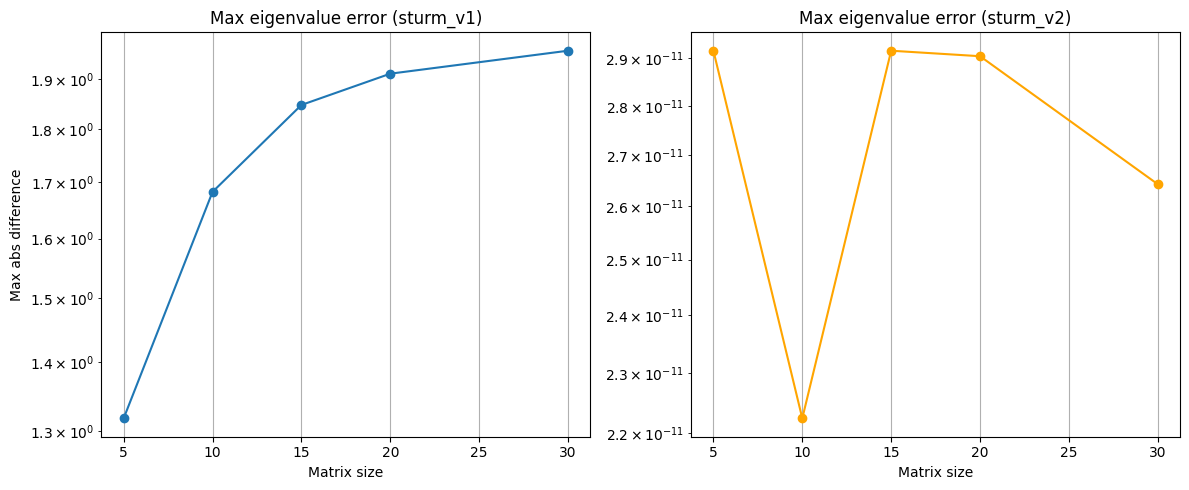

In [37]:
import matplotlib.pyplot as plt

matrix_sizes = [5, 10, 15, 20, 30]
max_diffs_v2 = []
max_diffs_v1 = []

for n in matrix_sizes:
    A = create_test_matrix(n)
    eigs_v1 = symmetric_bisection(A, method="sturm_v1")
    eigs_v2 = symmetric_bisection(A, method="sturm_v2")
    eigs_np = np.linalg.eigvalsh(A)
    max_diffs_v1.append(np.max(np.abs(np.sort(eigs_v1) - np.sort(eigs_np))))
    max_diffs_v2.append(np.max(np.abs(np.sort(eigs_v2) - np.sort(eigs_np))))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs[0].plot(matrix_sizes, max_diffs_v1, marker='o', label='sturm_v1')
axs[0].set_title('Max eigenvalue error (sturm_v1)')
axs[0].set_xlabel('Matrix size')
axs[0].set_ylabel('Max abs difference')
axs[0].set_yscale('log')
axs[0].grid(True)

axs[1].plot(matrix_sizes, max_diffs_v2, marker='o', color='orange', label='sturm_v2')
axs[1].set_title('Max eigenvalue error (sturm_v2)')
axs[1].set_xlabel('Matrix size')
axs[1].set_yscale('log')
axs[1].grid(True)

plt.tight_layout()
plt.show()

This shows us that really along all the different matrix sizes the sturm_v2 method given below lemma 5.21 performs good we should also maybe track the computational time for the different matrix sizes


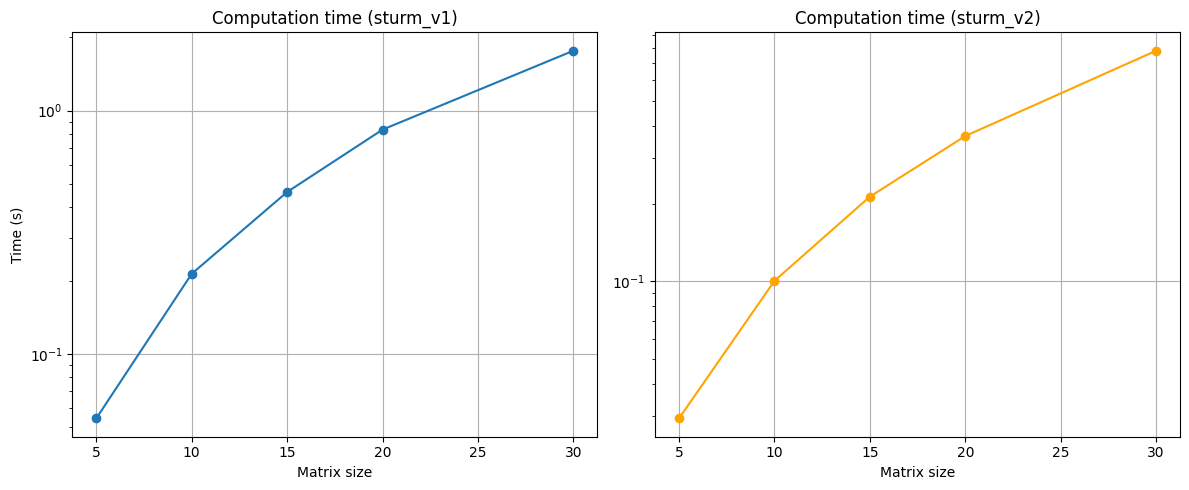

In [38]:
import time

times_v1 = []
times_v2 = []

for n in matrix_sizes:
    A = create_test_matrix(n)
    
    start = time.time()
    symmetric_bisection(A, method="sturm_v1")
    times_v1.append(time.time() - start)
    
    start = time.time()
    symmetric_bisection(A, method="sturm_v2")
    times_v2.append(time.time() - start)

fig_time, axs_time = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs_time[0].plot(matrix_sizes, times_v1, marker='o', label='sturm_v1')
axs_time[0].set_title('Computation time (sturm_v1)')
axs_time[0].set_xlabel('Matrix size')
axs_time[0].set_ylabel('Time (s)')
axs_time[0].set_yscale('log')
axs_time[0].grid(True)

axs_time[1].plot(matrix_sizes, times_v2, marker='o', color='orange', label='sturm_v2')
axs_time[1].set_title('Computation time (sturm_v2)')
axs_time[1].set_xlabel('Matrix size')
axs_time[1].set_yscale('log')
axs_time[1].grid(True)

plt.tight_layout()
plt.show()

We can see here also how the computation time scales with the matrix size, but again the sturm_v2 method performs better than the other one

# Exercise (4)

Goal of this exercise is to implement the **QR** Algorithm with and without shift to calculate the eigenvalues of a matrix

$A = S \Lambda S^{-1}$

where $S$ is a matrix with orthonormal columns and $\lambda$ is a diagonal matrix with the eigenvalues of $A$^



## Normal QR Algorithm

We know that similar matrices have the same eigenvalues and associated eigenvectors. Two square matrices $A$ and $B$ are similar if

\begin{equation}
A = C^{-1} B C
\end{equation}

**QR By Householder-Reflections**

We will compute multiple $Q_n$ matrices one at a time

$Q_n \cdot\cdot\cdot Q_2 Q_1 A = R$

and then multiply them all together in the end

first compute $||q_n||_2$ of the first column of our matrix. We will place this value at the first dimension of a wector and then substract $\vec{q_n}$

\begin{equation}
u = q_n - \begin{pmatrix}
||q_n||_2 \\ 0 \\ \vdots \\ 0
\end{pmatrix}
\end{equation}

Then we will normalize $u$ and call this $v$

$v = \frac{u}{||u||_2}$

We can then compute $Q_n$ as the first householder reflection

\begin{equation}
Q_n = I - 2 v v^T
\end{equation}

We will then iterate this process and start with a submatrix of $A$



In [39]:
def qr_householder(A,tol =1e-12):
    """ 
    Performs the QR Decomposition of matrix A using Householder reflections.
    """
    m,n = A.shape
    R = A.copy().astype(float)

    Q = np.identity(m) # Intialize Q

    # iterate over columns
    for i in range(n-1):

        # Extract first subcolumn
        x = R[i:, i]

        # Compute the norm and construct reflection vector
        alpha = np.linalg.norm(x,2)
        avec = np.zeros_like(x)
        avec[0] = alpha # target vector

        # Compute householder reflection vector
        u = x - avec

        # Normalize to get v
        if np.linalg.norm(u) > 1e-12:
            v = u / np.linalg.norm(u)
        else:
            v = u # if zero skip refleciton
        
        Qn_sub = np.identity(m-i) - 2*np.outer(v, v)  # Householder matrix for the submatrix

        # Embed Qn_sub into a full m x m matrix
        Q_n = np.block([[np.eye(i), np.zeros((i, m-i))],
                        [np.zeros((m-i, i)), Qn_sub]])
        # Apply reflection to R
        R = np.dot(Q_n, R)

        # Set values in R < tol to zero
        R[np.abs(R) < tol] = 0


        Q = np.dot(Q, Q_n.T)  # Accumilate the reflections
    return Q, R


In [40]:
# Test QR decomposition with Householder reflections
A = np.array([
        [4, 1, 1],
        [1, 3, 2],
        [1, 2, 4]
    ], dtype=float)

Q, R = qr_householder(A)
print("Matrix A:\n", A)
print("Q:\n", Q)
print("R:\n", R)
print("Q @ R:\n", Q @ R)

# Verify with numpy's QR decomposition
Q_np, R_np = np.linalg.qr(A)
print("Numpy Q:\n", Q_np)
print("Numpy R:\n", R_np)
print("Numpy Q @ R:\n", Q_np @ R_np)



Matrix A:
 [[4. 1. 1.]
 [1. 3. 2.]
 [1. 2. 4.]]
Q:
 [[ 0.94280904 -0.32444284 -0.07647191]
 [ 0.23570226  0.81110711 -0.53530338]
 [ 0.23570226  0.48666426  0.84119102]]
R:
 [[4.24264069 2.12132034 2.3570226 ]
 [0.         3.082207   3.24442842]
 [0.         0.         2.21768543]]
Q @ R:
 [[4. 1. 1.]
 [1. 3. 2.]
 [1. 2. 4.]]
Numpy Q:
 [[-0.94280904  0.32444284 -0.07647191]
 [-0.23570226 -0.81110711 -0.53530338]
 [-0.23570226 -0.48666426  0.84119102]]
Numpy R:
 [[-4.24264069 -2.12132034 -2.3570226 ]
 [ 0.         -3.082207   -3.24442842]
 [ 0.          0.          2.21768543]]
Numpy Q @ R:
 [[4. 1. 1.]
 [1. 3. 2.]
 [1. 2. 4.]]


Looks good, only difference is the sign of the reflection but i think this is just a matter of convention 

Now we perform the the $QR$ algorithm to find the eigenvalues

**Algorithm**
1. $T_0 = A$
2. for $k=1,2,...$
3. $Q_k,R_k = T_k-1$ # QR decomposition
4. $T_k = R_k Q_k$



In [41]:
def qr_algorithm(A, max_iter=1000,tol=1e-10, plot_convergence=False):
    """ 
    Computes the eigenvalues of a matrix A using the QR algorithm without shifts
    """

    n = A.shape[0]
    T = A.copy().astype(float)
    # extract intermediate eigenvalues
    eigenvals_history = []

    for k in range(max_iter):
        Q,R = qr_householder(T, tol=tol) # QR decomposition

        # Updata T
        T = R @ Q
        # Store the intermediate eigenvalues
        eigenvals_history.append(np.diag(T))

        # Check for convergence (off diagonals are small)
        off_diagonal = np.sum(np.abs(T - np.diag(np.diag(T))))
        if off_diagonal < tol:
            break

    # Extract eigenvalues from the diagonal
    eigenvalues = np.diag(T)

    if plot_convergence:
        # Plot the convergence of eigenvalues in respect to iterations
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        for i in range(n):
            plt.plot(range(len(eigenvals_history)), [ev[i] for ev in eigenvals_history], label=f'Eigenvalue {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Eigenvalue')
        plt.title('Convergence of Eigenvalues in QR Algorithm')
        plt.legend()
        plt.grid()
        plt.show()
    return eigenvalues

    

In [42]:
def test_qr_algorithm(A, max_iter=1000, tol=1e-10):
    """ 
    Applies QR algorithm using numpy
    """
    T = A.copy().astype(float)
    for k in range(max_iter):
        Q, R = np.linalg.qr(T)  # QR decomposition using numpy
        T = R @ Q  # Update T

        # Check for convergence
        off_diagonal = np.sum(np.abs(T - np.diag(np.diag(T))))
        if off_diagonal < tol:
            break

    return np.diag(T)  # Return eigenvalues from the diagonal of T

In [43]:
Lambda = np.diag([1,2,6,30])

# Generate a random invertible matrix
S = np.random.rand(4, 4)
while np.linalg.cond(S) > 1e10: # Ensure good conditioning
    S = np.random.rand(4, 4)

A = S @ Lambda @ np.linalg.inv(S)  # Similarity transformation to get a random matrix with given eigenvalues

print("Matrix A:\n", A)

# Tranform A to Hessenberg form
H = hessenberg_reduction(A)
print("Hessenberg form of A:\n", H)

Matrix A:
 [[ -7.15485317   4.78679195  -0.52000679   9.28336864]
 [-28.64806376  20.58980947   5.37036754  17.41848114]
 [-32.3499001   20.81939988   6.00377333  22.04570869]
 [-20.45769593  11.42502333   1.04336487  19.56127038]]
Hessenberg form of A:
 [[-7.15485317e+00 -6.48880902e+00 -4.38712306e+00  6.92915768e+00]
 [ 4.78094647e+01  3.84227530e+01  7.82538028e+00 -2.52995459e+01]
 [-4.00296619e-16 -6.56585484e-01  6.07956970e+00 -2.74518668e+00]
 [-1.27070833e-15  2.22044605e-16 -8.26380068e-01  1.65253044e+00]]


In [44]:
numpy_eigenvalues = np.linalg.eigvalsh(A)
print("Eigenvalues using NumPy:\n", numpy_eigenvalues)

computed_eigenvalues = qr_algorithm(A)
print("Eigenvalues using QR algorithm:\n", computed_eigenvalues)

# Verify with numpy's QR algorithm
numpy_qr_eigenvalues = test_qr_algorithm(A)
print("Eigenvalues using NumPy's QR algorithm:\n", numpy_qr_eigenvalues)

Eigenvalues using NumPy:
 [-39.08631245  -6.88741986  15.93502065  69.03871166]
Eigenvalues using QR algorithm:
 [30.00000004  5.99999996  2.          1.        ]
Eigenvalues using NumPy's QR algorithm:
 [30.  6.  2.  1.]


In [45]:
# Apply Algorithm to Hessenberg form
computed_eigenvalues_hessenberg = qr_algorithm(H)
print("Eigenvalues using QR algorithm on Hessenberg form:\n", computed_eigenvalues_hessenberg)
numpy_eigenvalues_hessenberg = np.linalg.eigvalsh(H)
print("Eigenvalues using NumPy on Hessenberg form:\n", numpy_eigenvalues_hessenberg)

computer_eigenvalues_hessenberg_numpy = test_qr_algorithm(H)
print("Eigenvalues using NumPy's QR algorithm on Hessenberg form:\n", computer_eigenvalues_hessenberg_numpy)


Eigenvalues using QR algorithm on Hessenberg form:
 [29.99999988  6.00000012  2.          1.        ]
Eigenvalues using NumPy on Hessenberg form:
 [-37.33183395   1.50325786   6.22674054  68.60183556]
Eigenvalues using NumPy's QR algorithm on Hessenberg form:
 [30.  6.  2.  1.]


------------Convergence of eigenvalues for the original matrix:------------------


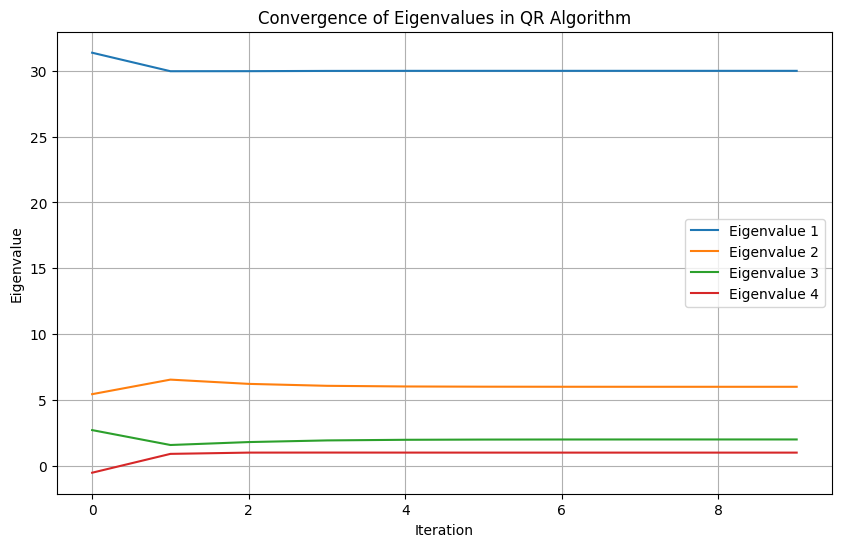

------------Convergence of eigenvalues for the Hessenberg form:------------------


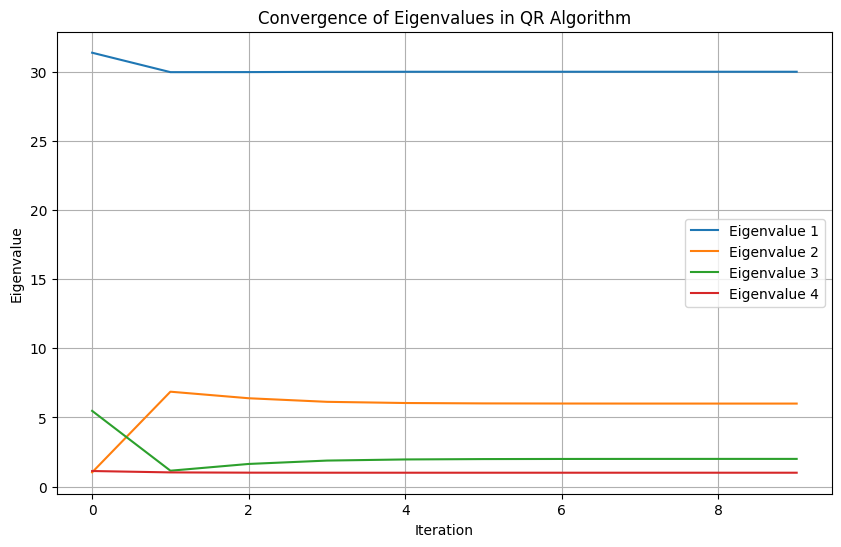

In [46]:
# Check the convergence before and after Hessenberg reduction
print("------------Convergence of eigenvalues for the original matrix:------------------")
eigenvalues_convergence = qr_algorithm(A, plot_convergence=True,max_iter=10)
# Check the convergence for the Hessenberg form
print("------------Convergence of eigenvalues for the Hessenberg form:------------------")
eigenvalues_convergence_hessenberg = qr_algorithm(H, plot_convergence=True,max_iter=10)

Both of the plots above show the convergence of the QR algorithm to the respective eigenvalues and also the convergence of the 

### QR Algorithm with Shift

Idea is to apply the QR-agorithm to the Matrix $A-pI$ where $p \approx \lambda_n$ 

**QR-Algorithm with Shift**
1. $T_0 = A$
2. for $k=1,2,...$
3. compute the shift parameter
4. $Q_kR_k = T_{k-1} - p_{k-1} I$ # QR decomposition
5. $T_k = R_k Q_k + p_{k-1} I

The shift parameters can be chosen by two ways 

1. $p_k = (T_k)_{n,n}$ works if $|\lambda_{n-1}| >  |\lambda_n|$
   
Second algorithm is to take a look at the sub matrix

\begin{equation}
\begin{pmatrix}
(T_k)_{n-1,n-1} & (T_k)_{n-1,n} \\
(T_k)_{n,n-1} & (T_k)_{n,n}
\end{pmatrix}
\end{equation}

with the eigenvalues $\mu_1,\mu_2$ if $\mu_1,\mu_2$ are real we take the one that is closer to $(T_k)_{n,n}$ otherwise if $\mu_1,\mu_2 = \alpha + i \beta$ we takte $p_k = \alpha + i \beta$ and $p_{k+1} = \alpha - i \beta$



In [47]:
def rayleigh_shift(T):
    """ 
    I think it is called this way i hope i dont offend Mr. Rayleigh here
    """
    return T[-1,-1] # Last diagonal element as shift

def wilkinson_shift(T):
    n = T.shape[0]
    submatrix = T[-2:, -2:]  # Last 2x2 submatrix
    eigenvals = np.linalg.eigvalsh(submatrix)

    if np.isreal(eigenvals).all():
        # Chose the eigenvalue closest to last diagonal element
        idx = np.argmin(np.abs(eigenvals - T[-1, -1]))
        return eigenvals[idx]
    else:
        # Complex case alternate shifts
        alpha = np.real(eigenvals[0])
        beta = np.imag(eigenvals[0])
        return alpha + beta * 1j  # Return complex shift


In [48]:
def qr_algorithm_with_shifts(A, max_iter=1000, tol=1e-10, shift_type="wilkinson", plot_convergence=False):
    """
    QR algorithm with shifts (Rayleigh or Wilkinson).
    Returns eigenvalues and convergence history.
    """
    n = A.shape[0]
    T = A.copy()
    eigenvalues_history = []
    shifts = []
    
    for k in range(max_iter):
        # Compute shift
        if shift_type == "rayleigh":
            p = rayleigh_shift(T)
        elif shift_type == "wilkinson":
            p = wilkinson_shift(T)
        else:
            raise ValueError("Invalid shift_type. Use 'rayleigh' or 'wilkinson'.")
        
        shifts.append(p)
        
        # QR decomposition of T - pI
        Q, R = qr_householder(T - p * np.eye(n))
        
        # Update T = RQ + pI
        T = R @ Q + p * np.eye(n)
        eigenvalues_history.append(np.diag(T))

        # Track convergence
        off_diag = np.sum(np.abs(T - np.diag(np.diag(T))))
        
        if off_diag < tol:
            break
    
    eigenvalues = np.diag(T)
    
    if plot_convergence:
        # Plot the convergence of eigenvalues
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        for i in range(n):
            plt.plot(range(len(eigenvalues_history)), [ev[i] for ev in eigenvalues_history], label=f'Eigenvalue {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Eigenvalue')
        plt.title('Convergence of Eigenvalues in QR Algorithm with Shifts')
        plt.legend()
        plt.grid()
        plt.show()
    
    return eigenvalues

In [49]:
Lambda = np.diag([1, 2, 6, 30])
S = np.random.rand(4, 4)
while np.linalg.cond(S) > 1e10:  # Ensure good conditioning
    S = np.random.rand(4, 4)
A = S @ Lambda @ np.linalg.inv(S)  # Similarity transformation to get a random matrix with given eigenvalues
print("Matrix A:\n", A)

H = hessenberg_reduction(A)
print("Hessenberg form of A:\n", H)

Matrix A:
 [[ 2.43600462  5.21843025  0.57696795 -2.39082379]
 [ 2.67972015 37.37473655 -3.09420404 -7.39282477]
 [-2.22673073 -1.34158181  6.34052193  2.32707588]
 [ 3.18673965 37.68049452 -3.11120004 -7.1512631 ]]
Hessenberg form of A:
 [[ 2.43600462e+00 -1.07593396e+00 -2.26145184e+00 -5.19703246e+00]
 [-4.72170938e+00  2.32288092e+01  1.27096405e+01  4.10255092e+01]
 [-5.18584894e-16  1.01351796e+01  1.29815383e+01  1.82297155e+01]
 [-9.09988683e-16  0.00000000e+00 -1.12307204e+00  3.53647939e-01]]


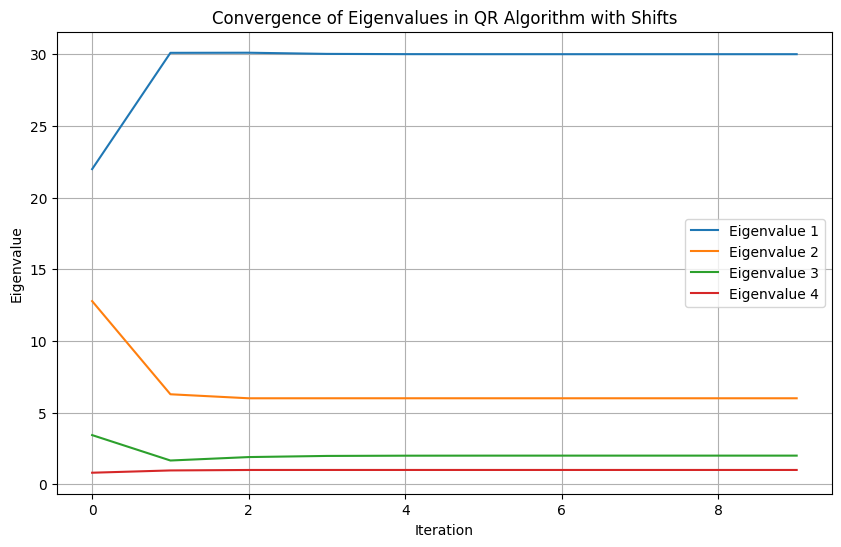

Eigenvalues using QR algorithm with Rayleigh shift:
 [30.00000056  6.0000008   1.99999864  1.        ]


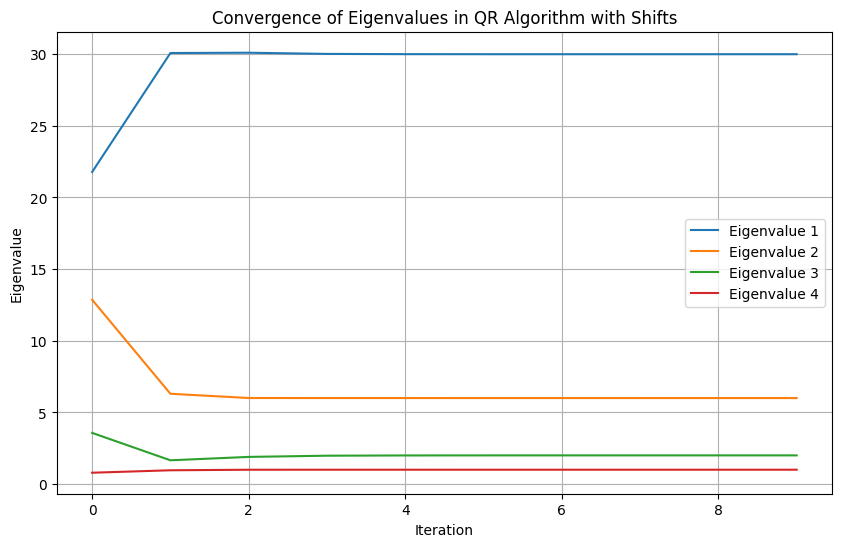

Eigenvalues using QR algorithm with Wilkinson shift:
 [30.00000057  6.00000088  1.99999855  1.        ]


In [50]:
eigenvalues_rayleigh = qr_algorithm_with_shifts(H,max_iter=10, shift_type="rayleigh", plot_convergence=True)
print("Eigenvalues using QR algorithm with Rayleigh shift:\n", eigenvalues_rayleigh)
eigenvalues_wilkinson = qr_algorithm_with_shifts(H,max_iter=10, shift_type="wilkinson", plot_convergence=True)
print("Eigenvalues using QR algorithm with Wilkinson shift:\n", eigenvalues_wilkinson)

Finally we see that this speed up the convergence quite good, although with this small matrices i dont see a big difference between Rayleigh and Wilkinson

Matrix A:
 [[ 1.26820410e+01 -6.65341998e+02  3.90305695e+02  2.04589724e+02
   4.08407339e+02  3.05715406e+02 -2.78143554e+02  5.99363722e+02
   4.35838882e+02 -1.37095062e+02  3.06979655e+02 -6.64114287e+01
  -9.95385097e+02 -2.39455726e+02]
 [-7.87189160e+02  7.47257553e+01  3.55095024e+02  5.09726586e+01
   3.94035538e+02  6.21879994e+02 -1.70095318e+02 -3.18705954e+01
   5.14405659e+02 -1.03271403e+03  3.89066170e+02  1.97000653e+02
   3.03458912e+02 -3.37149658e+02]
 [-3.79699394e+02 -3.89968751e+02  6.01515394e+02  3.49622021e+01
   4.22424726e+02  3.57174901e+02 -4.29427591e+02  7.90422201e+02
   1.55834573e+02 -1.91531015e+02  2.73421435e+02 -1.85362149e+02
  -9.28989866e+02  1.15018893e+02]
 [ 1.45301404e+02 -5.50302070e+02  1.91687954e+02  2.09527983e+02
   1.62344918e+02 -1.47812710e+00 -3.07891789e+01  4.02495754e+02
   1.56299084e+02  2.11369414e+02  1.90210843e+02 -1.07531593e+01
  -9.25933793e+02 -5.05481145e+01]
 [-3.17549268e+02 -4.08403666e+02  1.07295587e+02  1.7585

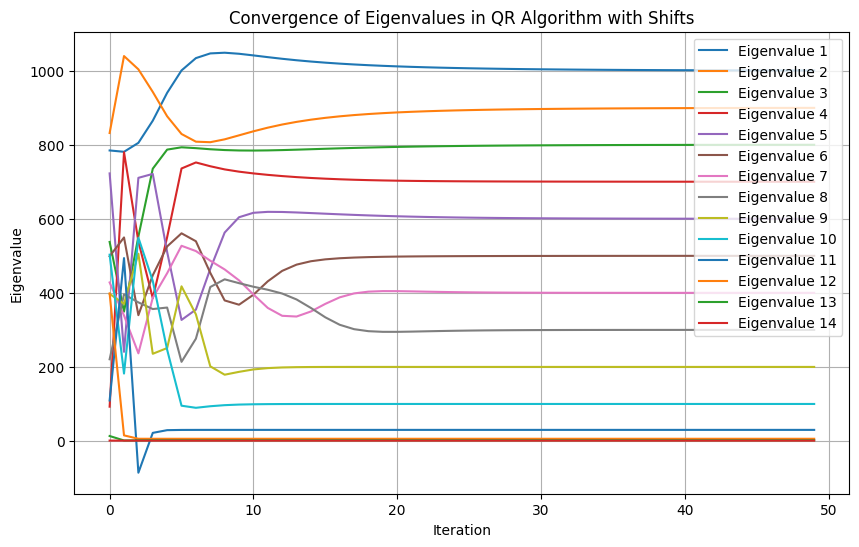

Eigenvalues using QR algorithm with Rayleigh shift on big matrix:
 [1.00047895e+03 8.99558599e+02 7.99857264e+02 7.00053366e+02
 6.00065797e+02 4.99988010e+02 3.99999938e+02 2.99998078e+02
 2.00000000e+02 1.00000000e+02 3.00000000e+01 6.00000001e+00
 2.00000000e+00 1.00000000e+00]


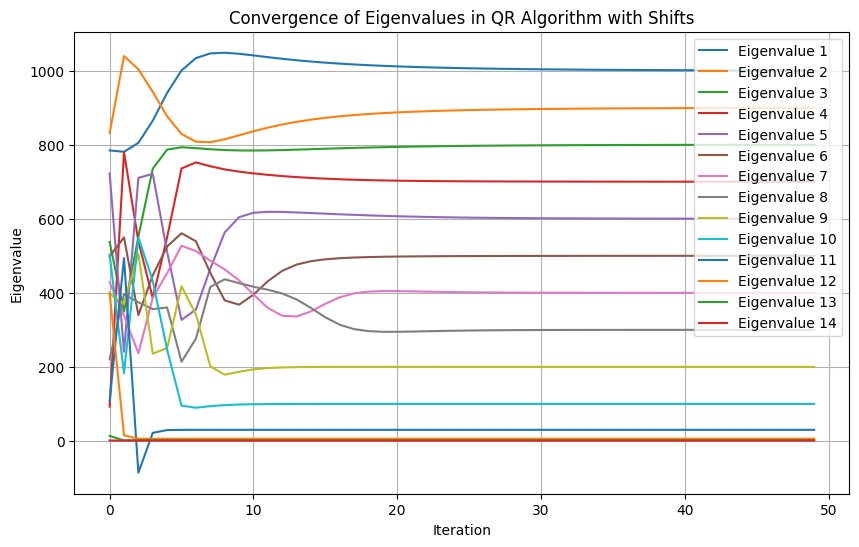

In [51]:
# Try really big matrixes

Lambda = np.diag([1, 2, 6, 30, 100, 200, 300, 400, 500, 600,700, 800, 900, 1000])
n = Lambda.shape[0]
S = np.random.rand(n, n)
while np.linalg.cond(S) > 1e10:  # Ensure good conditioning
    S = np.random.rand(10, 10)
A = S @ Lambda @ np.linalg.inv(S)  # Similarity transformation to get a random matrix with given eigenvalues
print("Matrix A:\n", A)
H = hessenberg_reduction(A)
print("Hessenberg form of A:\n", H)
eigenvalues_rayleigh_big = qr_algorithm_with_shifts(H, max_iter=50, shift_type="rayleigh", plot_convergence=True)
print("Eigenvalues using QR algorithm with Rayleigh shift on big matrix:\n", eigenvalues_rayleigh_big)
eigenvalues_wilkinson_big = qr_algorithm_with_shifts(H, max_iter=50, shift_type="wilkinson", plot_convergence=True)

Hmm maybe some difference but is hard to tell,

but at least the plot looks cool